# AR和PSY因子均线得分上升趋势策略 - 第四组 - 陈孜越

策略概述：
1.	构造了AR和PSY情绪类技术指标，再将两个指标的均线组得分加总，总得分若超过一定阈值则生成金叉信号，若低于一定阈值则生成死叉信号。
2.	趋势识别，利用收盘价均线金叉死叉进行上涨和下跌趋势的识别，上涨标记为1，下跌标记为-1
3.  每小时进行调仓判断。只有当品种处于上涨趋势时出现金叉或死叉信号时进行调仓。金叉信号出现则做多，死叉信号出现则做空
4.	每分钟进行止盈止损的判断 

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import pandas as pd
import numpy as np

########################################################################
# 策略继承CtaTemplate
class ARPSYUptrendStrategy(CtaTemplate):
    
    className = 'ARPSYUptrendStrategy'
    author = 'Chenziyue'
    
    # 策略参数
    fastPeriod = 15   # 判断趋势用到的短期均线时间长度 
    slowPeriod = 36   # 判断趋势用到的长期均线时间长度
    arPeriod = 15     # AR指标的时间参数
    psyPeriod = 8     # PSY指标的时间参数
    timePeriod = 10    # 均线组的个数
    multiplier = 5    # 长短期乘数
    upperthreshold = 0.6   # 买进的分数门槛
    lowerthreshold = 0.4   # 卖出的分数门槛
    stopRatio = 0.03    # 止损率
    lot = 1             # 设置手数
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod',
                 'arPeriod',
                 'psyPeriod',
                 'timePeriod',
                 'multiplier',
                 'upperthreshold',
                 'lowerthreshold',
                 'stopRatio',
                 'lot']    
    
    # 变量列表
    varList = ['maTrend',
               'transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.maTrend = {s:0 for s in self.symbolList} 
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                #print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                #print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                #print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                #print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势-------------------------------------------------
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if (fastMa[-1] > slowMa[-1]) and (fastMa[-2] < slowMa[-2]):
            self.maTrend[symbol] = 1
        elif (fastMa[-1] < slowMa[-1]) and (fastMa[-2] > slowMa[-2]):
            self.maTrend[symbol] = -1
        else:
            self.maTrend[symbol] = self.maTrend[symbol]
        
        # 计算策略需要的信号-------------------------------------------------
        def calculate(factor,t):
            mas = ta.MA(factor, t)
            mal = ta.MA(factor, self.multiplier*t)
            df = np.vstack((mas,mal))
            scoretable = np.array(list(map(lambda s, l: 1 if s>l else 0, df[0,:], df[1,:])))
            return scoretable
        
        ar = ta.SUM(am60.high[1:]-am60.open[1:],self.arPeriod)/ta.SUM(am60.open[1:]-am60.low[1:],self.arPeriod)
        x = range(1,self.timePeriod+1,1)
        arscore = np.array([calculate(ar,t) for t in x]).transpose().sum(axis=1)
            
        psy = ta.SUM(np.array(am60.close[1:]>am60.close[:-1],dtype='double'),self.psyPeriod)/self.psyPeriod
        psyscore = np.array([calculate(psy,t) for t in x]).transpose().sum(axis=1)
        
        score = arscore+psyscore
     
        crossOver = (score[-1]>2*self.timePeriod*self.upperthreshold) and (score[-2]<2*self.timePeriod*self.upperthreshold)
        crossBelow = (score[-1]<2*self.timePeriod*self.lowerthreshold) and (score[-2]>2*self.timePeriod*self.lowerthreshold)
        
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉出现，趋势向上
        if (crossOver) and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']<5):
            # 如果没有空头持仓，则直接做多
            if self.posDict[symbol+'_SHORT']==0:
                self.cancelAll()
                self.buy(symbol, bar.close*1.05, self.lot)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.05, self.lot)
        # 如果死叉出现，趋势向下
        elif (crossBelow) and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_SHORT']<5):
            if self.posDict[symbol+'_LONG']==0:
                self.cancelAll()
                self.short(symbol, bar.close*0.95, self.lot)
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.95, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
# 对BTCUSDT的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYUptrendStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function ARPSYUptrendStrategy.on60MinBar at 0x0000028ECE199A60>, <__main__.ARPSYUptrendStrategy object at 0x0000028EB9FC9EB8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ARPSYUptrendStrategy.onBar at 0x0000028ECE1999D8>, <__main__.ARPSYUptrendStrategy object at 0x0000028EB9FC9EB8>)
2018-12-16 14:44:15.596178	开始回测
2018-12-16 14:44:15.596178	策略初始化
2018-12-16 14:44:15.596178	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-16 14:44:15.950929	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 14:44:15.952980	载入完成，数据量：12000
2018-12-16 14:44:15.952980	策略初始化完成
2018-12-16 14:44:15.952980	策略启动完成
2018-12-16 14:44:15.952980	开始回放回测数据,回测范围:[20180601 00:00,20181201 00:00)
2018-12-16 14:44:15.967884	载入历史数据。数据范围:[20180601 00:00,20181201 00:00)
2018-12-16 14:44:22.930262	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 14:44:22.991096	载入完成，数据量：26172

In [3]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-04 01:00:00,空,,,0.0,,开仓,1,,7703.87,0.0,None,,,1,2018-06-04 01:00:00,1,1,BTCUSDT:binance,1
2018-06-06 15:00:00,空,,,0.0,,开仓,2,,7633.02,0.0,None,,,2,2018-06-06 15:00:00,1,2,BTCUSDT:binance,2
2018-06-07 23:00:00,空,,,0.0,,开仓,3,,7691.34,0.0,None,,,3,2018-06-07 23:00:00,1,3,BTCUSDT:binance,3
2018-06-11 01:34:00,多,,,0.0,,平仓,4,,6973.73,0.0,None,,,4,2018-06-11 01:34:00,3,4,BTCUSDT:binance,4
2018-06-15 10:00:00,空,,,0.0,,开仓,5,,6584.48,0.0,None,,,5,2018-06-15 10:00:00,1,5,BTCUSDT:binance,5
2018-06-15 16:00:00,空,,,0.0,,开仓,6,,6563.47,0.0,None,,,6,2018-06-15 16:00:00,1,6,BTCUSDT:binance,6
2018-06-19 01:14:00,多,,,0.0,,平仓,7,,6764.20,0.0,None,,,7,2018-06-19 01:14:00,2,7,BTCUSDT:binance,7
2018-06-19 20:00:00,多,,,0.0,,开仓,8,,6726.11,0.0,None,,,8,2018-06-19 20:00:00,1,8,BTCUSDT:binance,8
2018-06-22 15:10:00,空,,,0.0,,平仓,9,,6514.86,0.0,None,,,9,2018-06-22 15:10:00,1,9,BTCUSDT:binance,9


2018-12-16 14:44:38.947593	计算按日统计结果
2018-12-16 14:44:38.977718	------------------------------
2018-12-16 14:44:38.977823	首个交易日：	2018-06-01 00:00:00
2018-12-16 14:44:38.977823	最后交易日：	2018-11-30 00:00:00
2018-12-16 14:44:38.977823	总交易日：	183
2018-12-16 14:44:38.978020	盈利交易日	83
2018-12-16 14:44:38.978020	亏损交易日：	64
2018-12-16 14:44:38.978020	起始资金：	1000000
2018-12-16 14:44:38.978098	结束资金：	1,013,675.46
2018-12-16 14:44:38.978098	总收益率：	1.37%
2018-12-16 14:44:38.978186	年化收益：	1.79%
2018-12-16 14:44:38.978186	总盈亏：	13,675.46
2018-12-16 14:44:38.978235	最大回撤: 	-1,692.86
2018-12-16 14:44:38.978255	百分比最大回撤: -0.17%
2018-12-16 14:44:38.978282	总手续费：	542.47
2018-12-16 14:44:38.978310	总滑点：	0.33
2018-12-16 14:44:38.978323	总成交金额：	1,084,945.3
2018-12-16 14:44:38.978342	总成交笔数：	138
2018-12-16 14:44:38.978363	日均盈亏：	74.73
2018-12-16 14:44:38.978390	日均手续费：	2.96
2018-12-16 14:44:38.978413	日均滑点：	0.0
2018-12-16 14:44:38.978426	日均成交金额：	5,928.66
2018-12-16 14:44:38.978452	日均成交笔数：	0.75
2018-12-16 14:44:38.978474	日均收益率：	

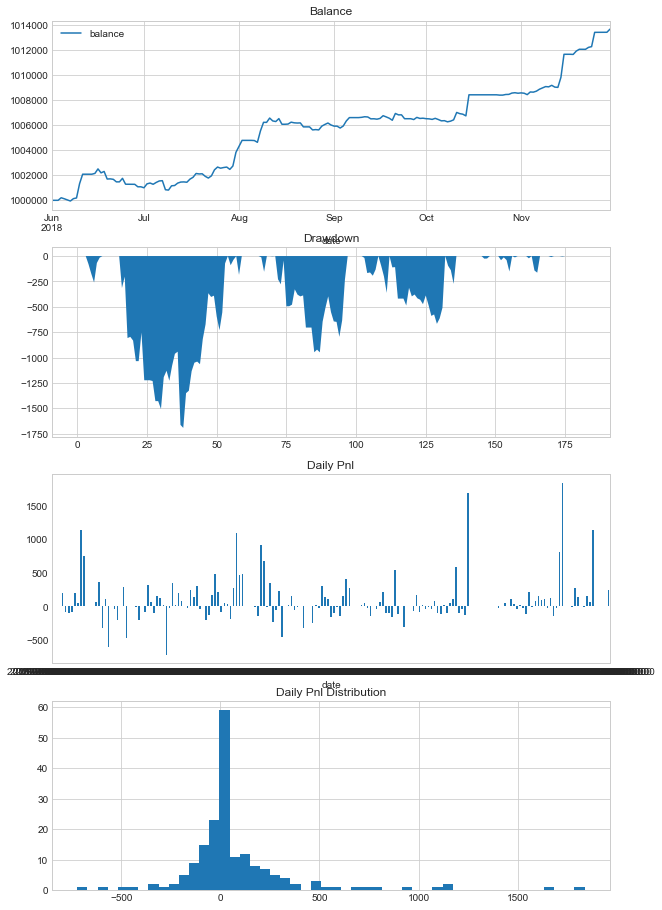

In [4]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 14:44:40.727902	计算回测结果
2018-12-16 14:44:40.732890	------------------------------
2018-12-16 14:44:40.732890	第一笔交易：	2018-06-11 01:34:00
2018-12-16 14:44:40.732890	最后一笔交易：	2018-11-30 23:58:00
2018-12-16 14:44:40.732890	总交易次数：	83
2018-12-16 14:44:40.732890	总盈亏：	13,673.44
2018-12-16 14:44:40.732890	最大回撤: 	-1,239.57
2018-12-16 14:44:40.733815	平均每笔盈利：	164.74
2018-12-16 14:44:40.733815	平均每笔滑点：	0.0
2018-12-16 14:44:40.733899	平均每笔佣金：	6.56
2018-12-16 14:44:40.733971	胜率		57.83%
2018-12-16 14:44:40.733971	盈利交易平均值	373.05
2018-12-16 14:44:40.734033	亏损交易平均值	-120.95
2018-12-16 14:44:40.734033	盈亏比：	3.08


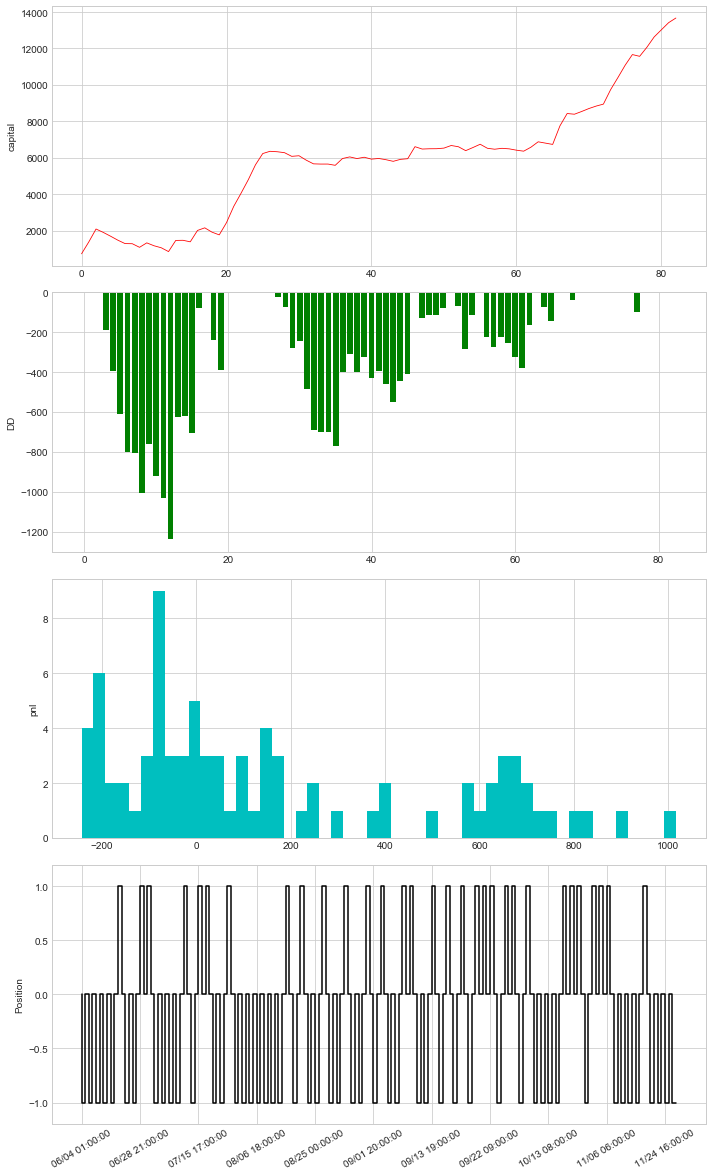

In [5]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [7]:
# 对EOSUSDT的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 00:00',initHours=50) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYUptrendStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function ARPSYUptrendStrategy.on60MinBar at 0x0000028EE1F11510>, <__main__.ARPSYUptrendStrategy object at 0x0000028EE0293B70>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function ARPSYUptrendStrategy.onBar at 0x0000028EE1F11488>, <__main__.ARPSYUptrendStrategy object at 0x0000028EE0293B70>)
2018-12-16 14:54:47.029501	开始回测
2018-12-16 14:54:47.029501	策略初始化
2018-12-16 14:54:47.030467	载入历史数据。数据范围:[20180628 22:00,20180701 00:00)
2018-12-16 14:54:47.138178	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 14:54:47.138178	载入完成，数据量：3000
2018-12-16 14:54:47.138178	策略初始化完成
2018-12-16 14:54:47.138178	策略启动完成
2018-12-16 14:54:47.138178	开始回放回测数据,回测范围:[20180701 00:00,20181201 00:00)
2018-12-16 14:54:47.164146	载入历史数据。数据范围:[20180701 00:00,20181201 00:00)
2018-12-16 14:54:53.044855	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 14:54:53.088269	载入完成，数据量：219233

Traceback (most recent call last):
  File "C:\Users\chenziyue\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev1811225-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\chenziyue\Anaconda3\lib\site-packages\pandas\core\generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180626090000 , 20180630230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180701000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180701000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 8.0545, 'high': 8.0734, 'low': 7.9332000000000003, 'close': 7.9964000000000004, 'date': '20180701', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 0, 0), 'volume': 347359.58999999991, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180626200000 , 20180701000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180701000000
2018-12-16 14:55:06.283728	数据回放结束ss: 100%    


2018-12-16 14:55:06.288720	计算按日统计结果
2018-12-16 14:55:06.308661	------------------------------
2018-12-16 14:55:06.309502	首个交易日：	2018-07-01 00:00:00
2018-12-16 14:55:06.309524	最后交易日：	2018-11-30 00:00:00
2018-12-16 14:55:06.309544	总交易日：	153
2018-12-16 14:55:06.309558	盈利交易日	49
2018-12-16 14:55:06.309571	亏损交易日：	43
2018-12-16 14:55:06.309583	起始资金：	1000000
2018-12-16 14:55:06.309596	结束资金：	1,000,005.81
2018-12-16 14:55:06.309640	总收益率：	0.0%
2018-12-16 14:55:06.309666	年化收益：	0.0%
2018-12-16 14:55:06.309666	总盈亏：	5.81
2018-12-16 14:55:06.309666	最大回撤: 	-1.63
2018-12-16 14:55:06.309666	百分比最大回撤: -0.0%
2018-12-16 14:55:06.309666	总手续费：	0.41
2018-12-16 14:55:06.309666	总滑点：	0.28
2018-12-16 14:55:06.309666	总成交金额：	821.63
2018-12-16 14:55:06.309666	总成交笔数：	125
2018-12-16 14:55:06.309666	日均盈亏：	0.04
2018-12-16 14:55:06.309666	日均手续费：	0.0
2018-12-16 14:55:06.309666	日均滑点：	0.0
2018-12-16 14:55:06.309666	日均成交金额：	5.37
2018-12-16 14:55:06.309666	日均成交笔数：	0.82
2018-12-16 14:55:06.309666	日均收益率：	0.0%
2018-12-16 14:55:06.

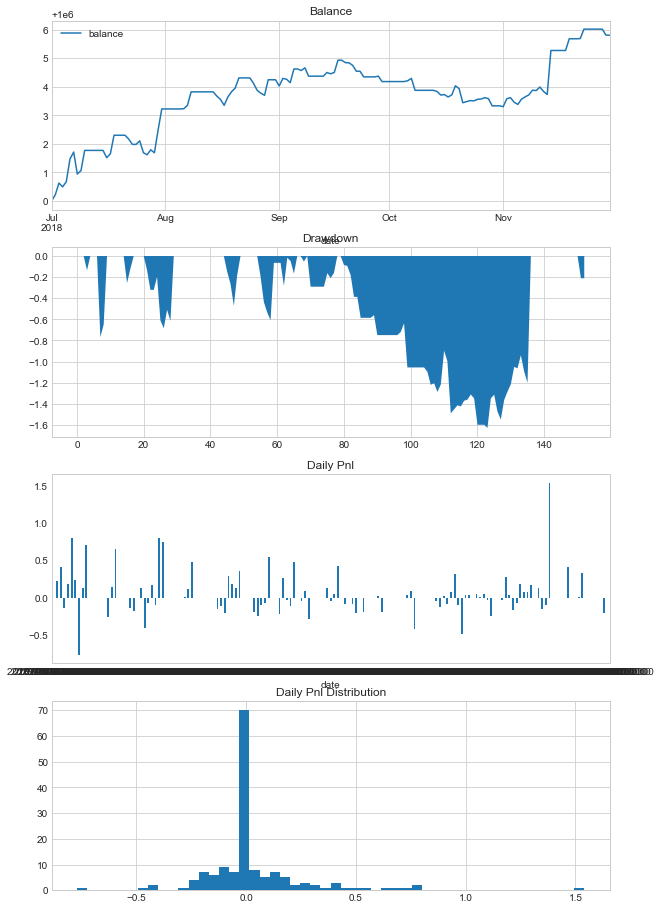

In [8]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 14:55:08.111838	计算回测结果
2018-12-16 14:55:08.117866	------------------------------
2018-12-16 14:55:08.118770	第一笔交易：	2018-07-03 14:00:00
2018-12-16 14:55:08.118822	最后一笔交易：	2018-11-29 17:19:00
2018-12-16 14:55:08.118883	总交易次数：	70
2018-12-16 14:55:08.118922	总盈亏：	5.81
2018-12-16 14:55:08.118922	最大回撤: 	-1.6
2018-12-16 14:55:08.118922	平均每笔盈利：	0.08
2018-12-16 14:55:08.118922	平均每笔滑点：	0.0
2018-12-16 14:55:08.118993	平均每笔佣金：	0.01
2018-12-16 14:55:08.119013	胜率		45.71%
2018-12-16 14:55:08.119032	盈利交易平均值	0.34
2018-12-16 14:55:08.119051	亏损交易平均值	-0.13
2018-12-16 14:55:08.119070	盈亏比：	2.58


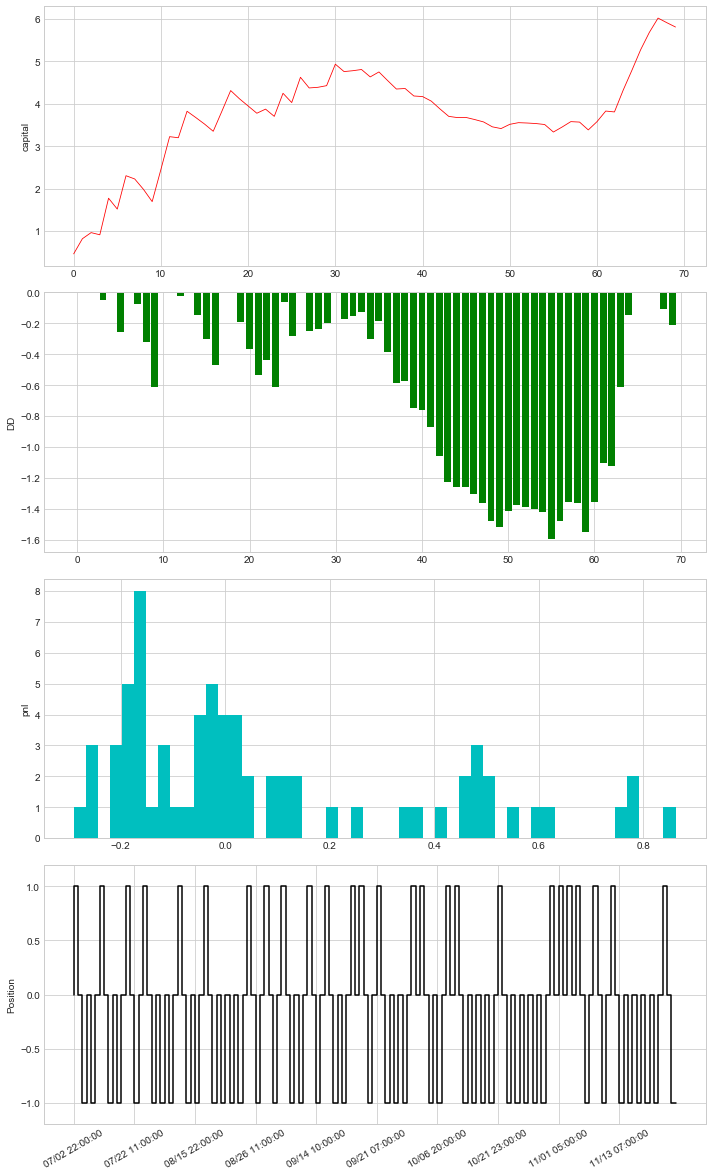

In [9]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [10]:
# 跨周期测试

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import pandas as pd
import numpy as np

########################################################################
# 策略继承CtaTemplate
class ARPSYUptrendStrategy(CtaTemplate):
    
    className = 'ARPSYUptrendStrategy'
    author = 'Chenziyue'
    
    # 策略参数
    fastPeriod = 15   # 判断趋势用到的短期均线时间长度 
    slowPeriod = 36   # 判断趋势用到的长期均线时间长度
    arPeriod = 15     # AR指标的时间参数
    psyPeriod = 8     # PSY指标的时间参数
    timePeriod = 10    # 均线组的个数
    multiplier = 5    # 长短期乘数
    upperthreshold = 0.6   # 买进的分数门槛
    lowerthreshold = 0.4   # 卖出的分数门槛
    stopRatio = 0.03    # 止损率
    lot = 1             # 设置手数
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod',
                 'arPeriod',
                 'psyPeriod',
                 'timePeriod',
                 'multiplier',
                 'upperthreshold',
                 'lowerthreshold',
                 'stopRatio',
                 'lot']    
    
    # 变量列表
    varList = ['maTrend',
               'transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.maTrend = {s:0 for s in self.symbolList} 
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                #print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                #print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                #print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                #print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """收到30分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am30 = self.getArrayManager(symbol, "30m") # 获取历史数组
        
        if not am30.inited:
            return
        
        # 计算均线并判断趋势-------------------------------------------------
        fastMa = ta.MA(am30.close, self.fastPeriod)
        slowMa = ta.MA(am30.close, self.slowPeriod)
        
        if (fastMa[-1] > slowMa[-1]) and (fastMa[-2] < slowMa[-2]):
            self.maTrend[symbol] = 1
        elif (fastMa[-1] < slowMa[-1]) and (fastMa[-2] > slowMa[-2]):
            self.maTrend[symbol] = -1
        
        # 计算策略需要的信号-------------------------------------------------
        def calculate(factor,t):
            mas = ta.MA(factor, t)
            mal = ta.MA(factor, self.multiplier*t)
            df = np.vstack((mas,mal))
            scoretable = np.array(list(map(lambda s, l: 1 if s>l else 0, df[0,:], df[1,:])))
            return scoretable
        
        ar = ta.SUM(am30.high[1:]-am30.open[1:],self.arPeriod)/ta.SUM(am30.open[1:]-am30.low[1:],self.arPeriod)
        x = range(1,self.timePeriod+1,1)
        arscore = np.array([calculate(ar,t) for t in x]).transpose().sum(axis=1)
            
        psy = ta.SUM(np.array(am30.close[1:]>am30.close[:-1],dtype='double'),self.psyPeriod)/self.psyPeriod
        psyscore = np.array([calculate(psy,t) for t in x]).transpose().sum(axis=1)
        
        score = arscore+psyscore
     
        crossOver = (score[-1]>2*self.timePeriod*self.upperthreshold) and (score[-2]<2*self.timePeriod*self.upperthreshold)
        crossBelow = (score[-1]<2*self.timePeriod*self.lowerthreshold) and (score[-2]>2*self.timePeriod*self.lowerthreshold)
        
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉出现，趋势向上
        if (crossOver) and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']<5):
            # 如果没有空头持仓，则直接做多
            if self.posDict[symbol+'_SHORT']==0:
                self.cancelAll()
                self.buy(symbol, bar.close*1.05, self.lot)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.05, self.lot)
        # 如果死叉出现，趋势向下
        elif (crossBelow) and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_SHORT']<5):
            if self.posDict[symbol+'_LONG']==0:
                self.cancelAll()
                self.short(symbol, bar.close*0.95, self.lot)
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.95, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [11]:
# 对BTCUSDT的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYUptrendStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function ARPSYUptrendStrategy.on30MinBar at 0x0000028EEFA86488>, <__main__.ARPSYUptrendStrategy object at 0x0000028EEFAB15F8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ARPSYUptrendStrategy.onBar at 0x0000028EEFA7DE18>, <__main__.ARPSYUptrendStrategy object at 0x0000028EEFAB15F8>)
2018-12-16 15:00:08.526731	开始回测
2018-12-16 15:00:08.526745	策略初始化
2018-12-16 15:00:08.526823	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-16 15:00:08.871772	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 15:00:08.874753	载入完成，数据量：12000
2018-12-16 15:00:08.874753	策略初始化完成
2018-12-16 15:00:08.874753	策略启动完成
2018-12-16 15:00:08.874753	开始回放回测数据,回测范围:[20180601 00:00,20181201 00:00)
2018-12-16 15:00:08.890747	载入历史数据。数据范围:[20180601 00:00,20181201 00:00)
2018-12-16 15:00:16.382669	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 15:00:16.448513	载入完成，数据量：26172

2018-12-16 15:00:33.391193	计算按日统计结果
2018-12-16 15:00:33.413173	------------------------------
2018-12-16 15:00:33.413173	首个交易日：	2018-06-01 00:00:00
2018-12-16 15:00:33.413173	最后交易日：	2018-11-30 00:00:00
2018-12-16 15:00:33.413173	总交易日：	183
2018-12-16 15:00:33.413173	盈利交易日	80
2018-12-16 15:00:33.413173	亏损交易日：	92
2018-12-16 15:00:33.413173	起始资金：	1000000
2018-12-16 15:00:33.413173	结束资金：	1,008,578.56
2018-12-16 15:00:33.413173	总收益率：	0.86%
2018-12-16 15:00:33.413173	年化收益：	1.13%
2018-12-16 15:00:33.413173	总盈亏：	8,578.56
2018-12-16 15:00:33.413173	最大回撤: 	-2,207.33
2018-12-16 15:00:33.413173	百分比最大回撤: -0.22%
2018-12-16 15:00:33.413173	总手续费：	1,298.29
2018-12-16 15:00:33.413173	总滑点：	0.79
2018-12-16 15:00:33.413173	总成交金额：	2,596,580.36
2018-12-16 15:00:33.413173	总成交笔数：	324
2018-12-16 15:00:33.413173	日均盈亏：	46.88
2018-12-16 15:00:33.413173	日均手续费：	7.09
2018-12-16 15:00:33.413173	日均滑点：	0.0
2018-12-16 15:00:33.413173	日均成交金额：	14,188.96
2018-12-16 15:00:33.413173	日均成交笔数：	1.77
2018-12-16 15:00:33.413173	日均收益

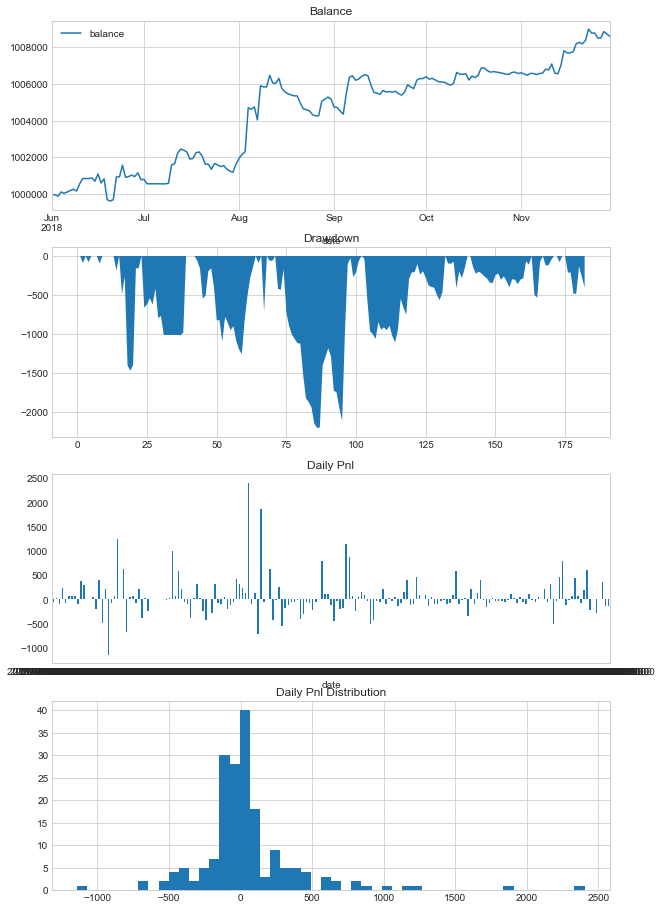

In [12]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 15:00:43.433135	计算回测结果
2018-12-16 15:00:43.445228	------------------------------
2018-12-16 15:00:43.446143	第一笔交易：	2018-06-02 13:00:00
2018-12-16 15:00:43.446143	最后一笔交易：	2018-11-30 18:19:00
2018-12-16 15:00:43.446143	总交易次数：	197
2018-12-16 15:00:43.446143	总盈亏：	8,578.56
2018-12-16 15:00:43.446143	最大回撤: 	-1,804.02
2018-12-16 15:00:43.446143	平均每笔盈利：	43.55
2018-12-16 15:00:43.446143	平均每笔滑点：	0.0
2018-12-16 15:00:43.446143	平均每笔佣金：	6.59
2018-12-16 15:00:43.446143	胜率		35.53%
2018-12-16 15:00:43.446143	盈利交易平均值	275.84
2018-12-16 15:00:43.446143	亏损交易平均值	-84.49
2018-12-16 15:00:43.446143	盈亏比：	3.26


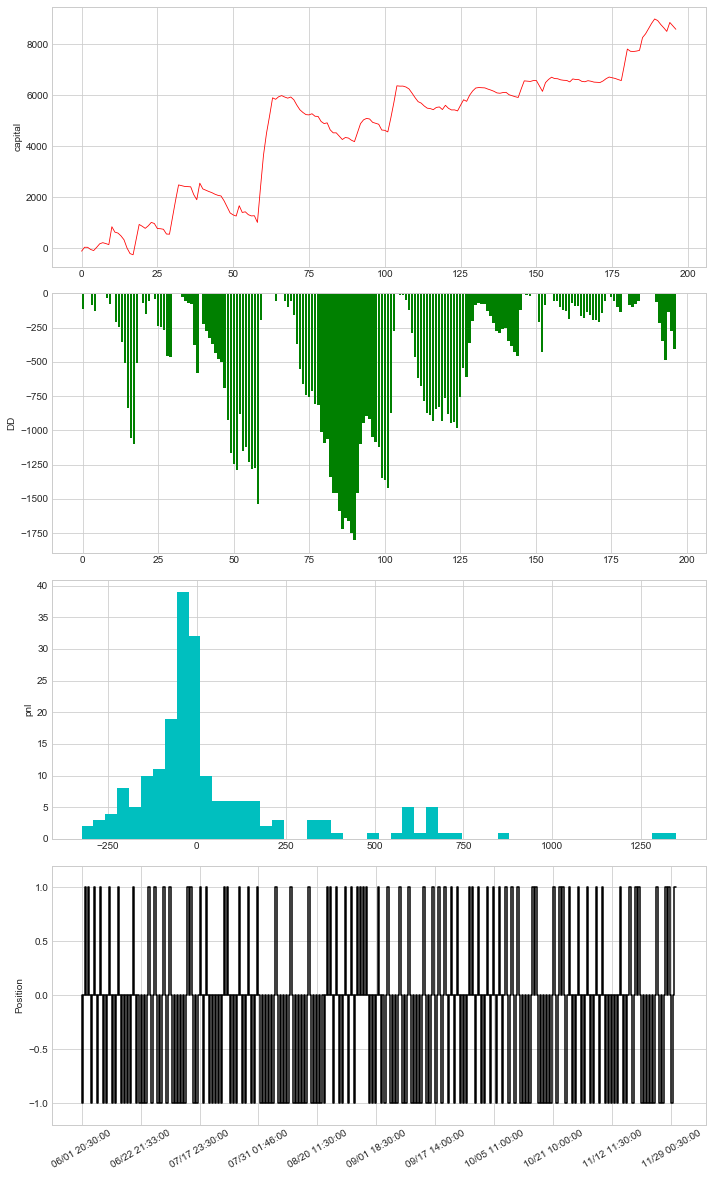

In [13]:
# 显示逐笔回测结果
engine.showBacktestingResult()